In [1]:
%matplotlib inline
import pandas as pd
import matplotlib # import for plots
import matplotlib.pyplot as plt # import for plots
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

#interim_path='ktbl\\interim\\' # path to store interim data - cut, filtered, resampled
interim_path="../data/final/"

interim_folder_content = []

total_df = pd.DataFrame(columns=['id','TgF', 'gFy', 'gFz', 'gF2d', 'label'])
label_dict={'swing':0,'jerk':1, 'snatch':2, 'none':3, 'noswing':4}

for path in os.listdir(interim_path): # check files in the interim data folder
    # check if current path is a file
    if os.path.isfile(os.path.join(interim_path, path)) and  path.endswith('.csv'): # check if path is a file
            interim_folder_content.append(path) # add files to the file list
    # print number of files in the interim data folder
    #print(len(interim_folder_content))
for idx,file_item in enumerate(interim_folder_content): # loop over files in the folder
    name_decomp=file_item.split('_') # split file names to look for labels
    current_df=pd.read_csv(interim_path+file_item)
    total_df.loc[idx]=[idx,current_df['TgF'].values, current_df['gFy'].values, current_df['gFz'].values, current_df['gFy'].values.tolist()+current_df['gFz'].values.tolist() , label_dict[name_decomp[-1][:-4]]]
    
#print(total_df.tail())
#print(len(total_df.loc[11]['TgF']))

#total_df['gF2d']=total_df['gFy'].tolist()+total_df['gFz'].tolist()
print(type(total_df['gFy'][1]))
print(total_df['gFz'][1])
print(len(total_df['gFy'][1]))
print(len(total_df['gF2d'][1]))
print(total_df['gF2d'][1])
print(total_df['gFy'][1]+total_df['gFz'][1])

<class 'numpy.ndarray'>
[0.06432619 0.06566207 0.1293893  0.25544711 0.41875408 0.73832213
 1.18538313 1.53084731 1.79659038 1.93724451 1.96613084 1.89542331
 1.87018832 1.90019608 1.79767006 1.62525693 1.4239728  1.19634048
 1.00822415 0.84258299 0.67871781 0.52132961 0.37867305 0.2766526
 0.27633277 0.38891187 0.5902167  0.82548252 1.02174304 1.1226252
 1.12517473 1.08590221 1.03344643 0.99026602 0.95718373 0.94024972
 0.93665914 0.94528231 0.95982034 0.96312563 0.93776915 0.86615032
 0.76241883 0.64781271 0.52609154 0.41710054 0.35336001 0.35014237
 0.42810492 0.58458581]
50
100
[0.2139765843737217, 0.2039797893828076, 0.140021996058173, 0.0624220711121085, 0.01166853792421, 0.0660550756606943, 0.2335888959169643, 0.4119675813863211, 0.6091730299311656, 0.6804453677033178, 0.6742453466702436, 0.6475669161115886, 0.6634328175985227, 0.7066642551923604, 0.7417263772398432, 0.755436651351901, 0.6922224668127962, 0.5693373930434553, 0.4476759477625999, 0.3130981272976221, 0.196542316555

In [2]:
num_classes=5

# random mask for test/train split
msk = np.random.rand(len(total_df)) < 0.8

# split original dataframe into test and train

train_df = total_df[msk]
test_df = total_df[~msk]

# convert from not parceble pandas dataframe to tensorflow acceptable format
x_train=train_df['gF2d'].to_list()
x_train=np.asarray(x_train).astype(np.float32)
y_train=train_df['label'].to_list()
y_train=np.asarray(y_train).astype(np.int32)




# create FCNN model good performing on time series data 
# https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
def make_model():
    # best model composition for 5 classes so far filters 20,32,32 600 epochs 
    # suppress early stopping by increasing patience to 100 and start evaluating performance from epoch 400
    input_layer = keras.layers.Input(shape=(100, 1))

    conv1 = keras.layers.Conv1D(filters=20, kernel_size=10, padding="same")(input_layer)
    #conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=32, kernel_size=10, padding="same")(conv1)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    
    conv3 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv2)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


def make_model_2():
    # best model composition for 5 classes so far filters 20,32,32 600 epochs 
    # suppress early stopping by increasing patience to 100 and start evaluating performance from epoch 400
    input_layer = keras.layers.Input(shape=(100, 1))

    # Reshape the input to separate gfx and gfy
    x = keras.layers.Reshape((50, 2))(input_layer)

    conv1 = keras.layers.Conv1D(filters=50, kernel_size=10, padding="same")(x)
    #conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=32, kernel_size=10, padding="same")(conv1)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    #conv3 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv2)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    #conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv2)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

# create model
model = make_model()
#plot model
keras.utils.plot_model(model, show_shapes=True)

# number of epochs to train 
epochs = 600
batch_size = 32


callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1, start_from_epoch=400),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

# print summary of model parameters
print(model.summary())

Epoch 1/600
8/8 [==============================] - 2s 54ms/step - loss: 1.5717 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.5124 - val_sparse_categorical_accuracy: 0.5156 - lr: 0.0010
Epoch 2/600
8/8 [==============================] - 0s 21ms/step - loss: 1.4971 - sparse_categorical_accuracy: 0.3730 - val_loss: 1.3897 - val_sparse_categorical_accuracy: 0.5156 - lr: 0.0010
Epoch 3/600
8/8 [==============================] - 0s 17ms/step - loss: 1.3829 - sparse_categorical_accuracy: 0.4802 - val_loss: 1.2812 - val_sparse_categorical_accuracy: 0.5938 - lr: 0.0010
Epoch 4/600
8/8 [==============================] - 0s 21ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.5198 - val_loss: 1.1620 - val_sparse_categorical_accuracy: 0.5938 - lr: 0.0010
Epoch 5/600
8/8 [==============================] - 0s 22ms/step - loss: 1.1453 - sparse_categorical_accuracy: 0.5198 - val_loss: 1.0554 - val_sparse_categorical_accuracy: 0.5938 - lr: 0.0010
Epoch 6/600
8/8 [============================

Epoch 44/600
8/8 [==============================] - 0s 15ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.1071 - val_sparse_categorical_accuracy: 0.9531 - lr: 0.0010
Epoch 45/600
8/8 [==============================] - 0s 20ms/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.0852 - val_sparse_categorical_accuracy: 0.9688 - lr: 0.0010
Epoch 46/600
8/8 [==============================] - 0s 12ms/step - loss: 0.1004 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.1376 - val_sparse_categorical_accuracy: 0.9531 - lr: 0.0010
Epoch 47/600
8/8 [==============================] - 0s 21ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.0777 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 48/600
8/8 [==============================] - 0s 20ms/step - loss: 0.0870 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.0929 - val_sparse_categorical_accuracy: 0.9531 - lr: 0.0010
Epoch 49/600
8/8 [======================

Epoch 87/600
8/8 [==============================] - 0s 16ms/step - loss: 0.0199 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0247 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 88/600
8/8 [==============================] - 0s 16ms/step - loss: 0.0210 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0280 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 89/600
8/8 [==============================] - 0s 19ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0249 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 90/600
8/8 [==============================] - 0s 20ms/step - loss: 0.0182 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0252 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 91/600
8/8 [==============================] - 0s 21ms/step - loss: 0.0167 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0216 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 92/600
8/8 [======================

8/8 [==============================] - 0s 20ms/step - loss: 0.0059 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0117 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 130/600
8/8 [==============================] - 0s 22ms/step - loss: 0.0061 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0113 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 131/600
8/8 [==============================] - 0s 20ms/step - loss: 0.0057 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0112 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 132/600
8/8 [==============================] - 0s 16ms/step - loss: 0.0059 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0114 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 133/600
8/8 [==============================] - 0s 17ms/step - loss: 0.0056 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0129 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 134/600
8/8 [==============================

8/8 [==============================] - 0s 19ms/step - loss: 0.0029 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0067 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 172/600
8/8 [==============================] - 0s 19ms/step - loss: 0.0029 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0066 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 173/600
8/8 [==============================] - 0s 20ms/step - loss: 0.0026 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0065 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 174/600
8/8 [==============================] - 0s 16ms/step - loss: 0.0025 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0068 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 175/600
8/8 [==============================] - 0s 16ms/step - loss: 0.0026 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0066 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 176/600
8/8 [==============================

8/8 [==============================] - 0s 17ms/step - loss: 0.0016 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0041 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 214/600
8/8 [==============================] - 0s 14ms/step - loss: 0.0016 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0047 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 215/600
8/8 [==============================] - 0s 15ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0043 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 216/600
8/8 [==============================] - 0s 20ms/step - loss: 0.0015 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0043 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 217/600
8/8 [==============================] - 0s 22ms/step - loss: 0.0019 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0040 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 218/600
8/8 [==============================

8/8 [==============================] - 0s 20ms/step - loss: 9.3493e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0029 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 256/600
8/8 [==============================] - 0s 14ms/step - loss: 8.9305e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0030 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 257/600
8/8 [==============================] - 0s 19ms/step - loss: 9.0455e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0028 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 258/600
8/8 [==============================] - 0s 21ms/step - loss: 8.9430e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0028 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 259/600
8/8 [==============================] - 0s 12ms/step - loss: 8.5213e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0029 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 260/600
8/8 [==========

Epoch 297/600
8/8 [==============================] - 0s 16ms/step - loss: 6.4467e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0024 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 298/600
8/8 [==============================] - 0s 18ms/step - loss: 5.9557e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0022 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 299/600
8/8 [==============================] - 0s 17ms/step - loss: 5.8590e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0023 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 300/600
8/8 [==============================] - 0s 19ms/step - loss: 5.8972e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0022 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 301/600
8/8 [==============================] - 0s 21ms/step - loss: 6.0088e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0022 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 302/600
8

8/8 [==============================] - 0s 22ms/step - loss: 4.2195e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0018 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 339/600
8/8 [==============================] - 0s 16ms/step - loss: 4.1399e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0018 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 340/600
8/8 [==============================] - 0s 17ms/step - loss: 4.3520e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0019 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 341/600
8/8 [==============================] - 0s 17ms/step - loss: 4.1167e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0019 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 342/600
8/8 [==============================] - 0s 22ms/step - loss: 4.1242e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0018 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 343/600
8/8 [==========

Epoch 380/600
8/8 [==============================] - 0s 19ms/step - loss: 2.9814e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0017 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 381/600
8/8 [==============================] - 0s 19ms/step - loss: 3.0124e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0017 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 382/600
8/8 [==============================] - 0s 22ms/step - loss: 2.9331e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0015 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 383/600
8/8 [==============================] - 0s 16ms/step - loss: 2.9507e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 384/600
8/8 [==============================] - 0s 17ms/step - loss: 3.0300e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 385/600
8

8/8 [==============================] - 0s 20ms/step - loss: 2.3986e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 422/600
8/8 [==============================] - 0s 16ms/step - loss: 2.4822e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0015 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 423/600
8/8 [==============================] - 0s 24ms/step - loss: 2.2277e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 424/600
8/8 [==============================] - 0s 16ms/step - loss: 2.2888e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0014 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 425/600
8/8 [==============================] - 0s 18ms/step - loss: 2.1876e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 426/600
8/8 [==========

8/8 [==============================] - 0s 17ms/step - loss: 1.8198e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 2.5000e-04
Epoch 463/600
8/8 [==============================] - 0s 20ms/step - loss: 1.8142e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 2.5000e-04
Epoch 464/600
8/8 [==============================] - 0s 18ms/step - loss: 1.8006e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 2.5000e-04
Epoch 465/600
8/8 [==============================] - 0s 15ms/step - loss: 1.8301e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 2.5000e-04
Epoch 466/600
8/8 [==============================] - 0s 16ms/step - loss: 1.8170e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 2.5000e-04
Epoch 467

Epoch 503/600
8/8 [==============================] - 0s 17ms/step - loss: 1.7160e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 504/600
8/8 [==============================] - 0s 18ms/step - loss: 1.7154e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 505/600
8/8 [==============================] - 0s 19ms/step - loss: 1.7122e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 506/600
8/8 [==============================] - 0s 17ms/step - loss: 1.7112e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 507/600
8/8 [==============================] - 0s 18ms/step - loss: 1.7183e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000

Epoch 544/600
8/8 [==============================] - 0s 22ms/step - loss: 1.6593e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 545/600
8/8 [==============================] - 0s 17ms/step - loss: 1.6587e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 546/600
8/8 [==============================] - 0s 18ms/step - loss: 1.6588e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 547/600
8/8 [==============================] - 0s 20ms/step - loss: 1.6554e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 548/600
8/8 [==============================] - 0s 19ms/step - loss: 1.6545e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000

Epoch 585/600
8/8 [==============================] - 0s 19ms/step - loss: 1.5954e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 586/600
8/8 [==============================] - 0s 15ms/step - loss: 1.5927e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 587/600
8/8 [==============================] - 0s 12ms/step - loss: 1.5990e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 588/600
8/8 [==============================] - 0s 15ms/step - loss: 1.5893e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 589/600
8/8 [==============================] - 0s 19ms/step - loss: 1.5907e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000 - lr: 1.0000

In [3]:
# load best trained model
model = keras.models.load_model("best_model.h5")

# 
x_test=test_df['gF2d'].to_list()
x_test=np.asarray(x_test).astype(np.float32)
y_test=test_df['label'].to_list()
y_test=np.asarray(y_test).astype(np.int32)


test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

3/3 [==============================] - 0s 6ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Test accuracy 1.0
Test loss 0.0018141838954761624


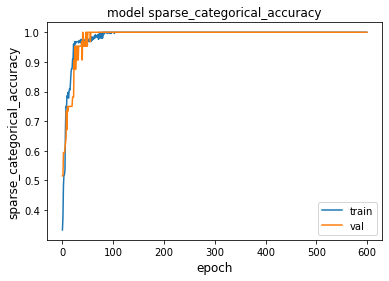

In [4]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

3/3 [==============================] - 0s 4ms/step


C:\Users\Andrey\AppData\Local\Temp\ipykernel_13500\469061981.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(np.arange(len(y_test)),  prediction_values, 'r.', marker='x' )
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


66
66
66


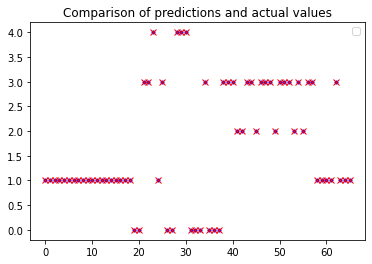

In [5]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(x_test, y_test)
# Make predictions based on our test dataset
predictions = model.predict(x_test)
prediction_values=[ element.tolist().index(max(element)) for element in predictions]

print(len(predictions))
print(len(prediction_values))
print(len(y_test))
# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(np.arange(len(y_test)), y_test, 'b.')
plt.plot(np.arange(len(y_test)),  prediction_values, 'r.', marker='x' )

plt.legend()
plt.show()

In [6]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Andrey\AppData\Local\Temp\tmp0c3cegk0\assets


INFO:tensorflow:Assets written to: C:\Users\Andrey\AppData\Local\Temp\tmp0c3cegk0\assets


In [7]:
# Save the model to disk
open("ktbl_model.tflite", "wb").write(tflite_model)

44300

In [8]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Indicate that we want to perform the default optimizations,
# which include quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
"""
def representative_dataset_generator():
    for value in x_test:
        # Each scalar value must be inside of a 2D array that is wrapped in a list
        yield [np.array(value, dtype=np.float32, ndmin=5)]
    
converter.representative_dataset = representative_dataset_generator
"""

#converter.representative_dataset = x_test
tflite_model = converter.convert()
# Save the model to disk
open("ktbl_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Andrey\AppData\Local\Temp\tmp4kyr_6qf\assets


INFO:tensorflow:Assets written to: C:\Users\Andrey\AppData\Local\Temp\tmp4kyr_6qf\assets


16728

In [9]:
#unfiltered data test

unfiltered_df = pd.DataFrame(columns=['id','TgF', 'gFy', 'gFz', 'label'])
label_dict={'swing':0,'jerk':1, 'snatch':2}
unfiltered_files = []


for path in os.listdir(interim_path): # check files in the interim data folder
    # check if current path is a file
    if os.path.isfile(os.path.join(interim_path, path)): # check if path is a file
            if path[-4:]=='.unf':
                   unfiltered_files.append(path) # add files to the file list
print(len(unfiltered_files))
           
    # print number of files in the interim data folder
    #print(len(interim_folder_content))
for idx,file_item in enumerate(unfiltered_files): # loop over files in the folder
    name_decomp=file_item.split('_') # split file names to look for labels
    current_df=pd.read_csv(interim_path+file_item)
    unfiltered_df.loc[idx]=[idx,current_df['TgF'].values, current_df['gFy'].values, current_df['gFz'].values, label_dict[name_decomp[-1][:-4]]]
    

141


In [10]:
"""
x_test=unfiltered_df['gF2d'].to_list()
x_test=np.asarray(x_test).astype(np.float32)
y_test=unfiltered_df['label'].to_list()
y_test=np.asarray(y_test).astype(np.int32)

"""

"\nx_test=unfiltered_df['gF2d'].to_list()\nx_test=np.asarray(x_test).astype(np.float32)\ny_test=unfiltered_df['label'].to_list()\ny_test=np.asarray(y_test).astype(np.int32)\n\n"

3/3 [==============================] - 0s 3ms/step


C:\Users\Andrey\AppData\Local\Temp\ipykernel_13500\469061981.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(np.arange(len(y_test)),  prediction_values, 'r.', marker='x' )


66
66
66


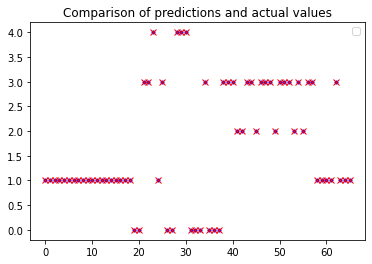

In [11]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(x_test, y_test)
# Make predictions based on our test dataset
predictions = model.predict(x_test)
prediction_values=[ element.tolist().index(max(element)) for element in predictions]

print(len(predictions))
print(len(prediction_values))
print(len(y_test))
# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(np.arange(len(y_test)), y_test, 'b.')
plt.plot(np.arange(len(y_test)),  prediction_values, 'r.', marker='x' )

plt.legend()
plt.show()

[-0.05168794 -0.02833366  0.0722939   0.20828994  0.37009305  0.6378635
  0.8134871   0.8913237   0.88980603  0.7843738   0.67872775  0.7082997
  0.7295863   0.7097726   0.685191    0.7133056   0.7625618   0.78593534
  0.7667053   0.72048724  0.6861733   0.69776267  0.7461428   0.79246
  0.8105612   0.8010051   0.76749533  0.7490454   0.75207496  0.77828693
  0.8118391   0.83579695  0.85020685  0.8444176   0.8268675   0.8118045
  0.8110639   0.8098872   0.8150359   0.82996935  0.8022847   0.7104566
  0.5690622   0.40052825  0.25986224  0.10113434  0.0369222   0.00791633
  0.00195105  0.00851597 -1.0664719  -1.2371634  -1.2810928  -1.1630263
 -0.9546669  -0.5766596  -0.18290655  0.13747577  0.45435727  0.57605976
  0.62797976  0.5919011   0.56502074  0.5572454   0.56279457  0.5686635
  0.57545745  0.5804726   0.5639478   0.54698354  0.5286164   0.5201656
  0.5223336   0.52602416  0.5251547   0.51933986  0.5049479   0.49353155
  0.48267597  0.47619995  0.4722971   0.4678538   0.45428726 

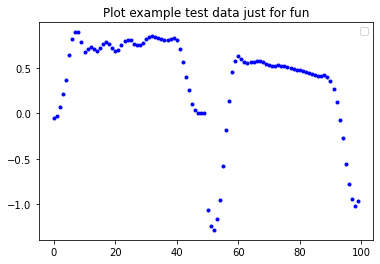

In [12]:
plt.clf()
plt.title('Plot example test data just for fun')
plot_data=x_test[51]
print(plot_data)
print(plot_data.shape)
plt.plot(np.arange(len(plot_data)), plot_data, 'b.')
#plt.plot(np.arange(len(y_test)),  prediction_values, 'r.', marker='x' )

plt.legend()
plt.show()

In [13]:

#plot_data=ktbl_4[(ktbl_4['rel_t']>12)  & (ktbl_4['rel_t']< 34) ]
#ktbl_6=pd.read_csv("../data/raw/ktbl_12.csv")
test_data_df=pd.read_csv("../data/raw/20241104-214025.csv", names=['time','gFx', 'gFy', 'gFz', 'TgF'], skiprows=1)

test_data_df['rel_t']=test_data_df['time']-test_data_df['time'][0]
span=1.6 # s
p_number=50 #number of points

t_start=test_data_df['rel_t'].values[0]
t_stop=test_data_df['rel_t'].values[-1]
t_steps=np.linspace(t_start,t_stop, num=int((t_stop-t_start)*10))
jerk_dist=np.empty(len(t_steps))
swing_dist=np.empty(len(t_steps))
snatch_dist=np.empty(len(t_steps))
none_dist=np.empty(len(t_steps))
noswing_dist=np.empty(len(t_steps))
total_prob=np.empty(len(t_steps))
xvals = np.linspace(0, span, p_number)

for idx,timestep in enumerate(t_steps):
    test_ts=test_data_df[(test_data_df['rel_t']>timestep-span)  & (test_data_df['rel_t']< timestep+span) ]
    #print(test_ts['rel_t'].values[0])
    start_time=test_ts['rel_t'].values[0]
    sliding_rel_time=test_ts['rel_t'].values-start_time
    sliding_gFy = np.interp(xvals, sliding_rel_time, test_ts['gFy'].values)
    sliding_gFz = np.interp(xvals, sliding_rel_time, test_ts['gFz'].values)
    sliding_TgF = np.interp(xvals, sliding_rel_time, test_ts['TgF'].values)
    sliding_gF2d = sliding_gFy.tolist()+sliding_gFz.tolist()
    #jerk_dist[idx]=(DTWDistance2(sliding_gFy,mean_jerk_gFy)**2+DTWDistance2(sliding_gFz,mean_jerk_gFz)**2)**0.5
    #swing_dist[idx]=(DTWDistance2(sliding_gFy,mean_swing_gFy)**2+DTWDistance2(sliding_gFz,mean_swing_gFz)**2)**0.5
    #snatch_dist[idx]=(DTWDistance2(sliding_gFy,mean_snatch_gFy)**2+DTWDistance2(sliding_gFz,mean_snatch_gFz)**2)**0.5
    #x_sliding=[sliding_TgF.tolist()]
    x_sliding=[sliding_gF2d]
    x_sliding=np.asarray(x_sliding).astype(np.float32)
    #print(x_sliding)
    #print(x_sliding.shape)
    predictions=model.predict(x_sliding, verbose = 0)
    #print(predictions)
    jerk_dist[idx]=predictions[0][1]
    swing_dist[idx]=predictions[0][0]
    snatch_dist[idx]=predictions[0][2]
    none_dist[idx]=predictions[0][3]
    noswing_dist[idx]=predictions[0][4]
    total_prob[idx]=jerk_dist[idx]+swing_dist[idx]+snatch_dist[idx]+noswing_dist[idx]


<IPython.core.display.Javascript object>


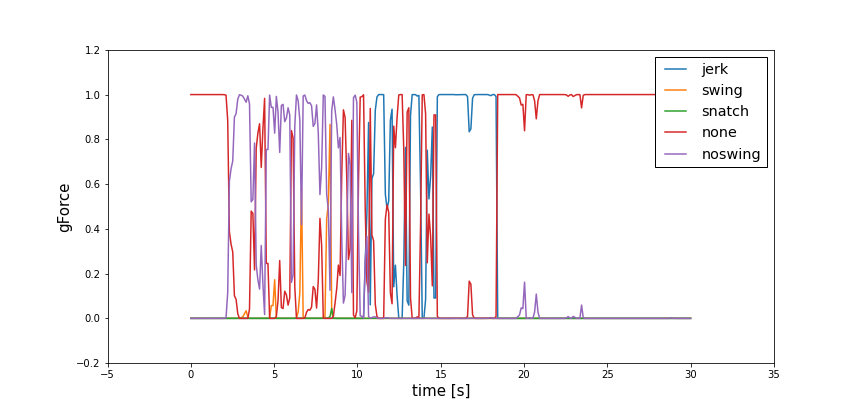

In [14]:
%matplotlib notebook
plt.plot(t_steps,jerk_dist, label='jerk')
plt.plot(t_steps,swing_dist, label='swing')  
plt.plot(t_steps,snatch_dist, label='snatch') 
plt.plot(t_steps,none_dist, label='none') 
plt.plot(t_steps,noswing_dist, label='noswing') 
#plt.plot(mean_jerk['rel_t'],mean_jerk['TgF'], label='TgF')  
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('gForce', fontsize=15)
plt.style.use('classic')
#plt.yscale("log")
plt.legend(loc='upper right')
plt.show()

In [44]:
print(total_prob[:100])

[0.00400606 0.00400606 0.00400606 0.00400606 0.00400606 0.00400606
 0.00395487 0.00383976 0.00341676 0.00302443 0.0027872  0.0025061
 0.00222164 0.00191198 0.00162163 0.00134484 0.00121259 0.00117058
 0.00118554 0.00117605 0.00117898 0.00125835 0.00135977 0.00145207
 0.00159402 0.00177977 0.00196618 0.00253494 0.00414968 0.00495595
 0.01163238 0.02158989 0.02754277 0.02371949 0.0208304  0.02103101
 0.0231757  0.02888242 0.03378802 0.03845258 0.04332111 0.04811303
 0.05961077 0.07158626 0.05326569 0.0214944  0.00426648 0.00137384
 0.00113796 0.00136668 0.00159669 0.0014014  0.00149044 0.00167465
 0.00189097 0.00222187 0.00227596 0.00276111 0.00265321 0.00210901
 0.00255012 0.00361401 0.00528624 0.00485332 0.00496934 0.00525023
 0.00604472 0.00837472 0.01161431 0.01052525 0.01128865 0.01491043
 0.01678653 0.01821327 0.02373429 0.03056796 0.04247627 0.04718565
 0.04987104 0.06667479 0.10382982 0.12402064 0.13879572 0.14685063
 0.19577177 0.20655918 0.21195308 0.23038211 0.24605318 0.24270

In [17]:
def purity_score(nclusters, data_labels, clusters):
    in_cluster_count= {}
    correspondence = {}
    cluster_labels = np.unique(clusters)
    N = len(data_labels)
    for k in range(len(cluster_labels)):
        cluster_label = cluster_labels[k]
        cluster = np.where(clusters ==cluster_label)
        if np.any(cluster):
            data_labels = np.array(data_labels, dtype='int')
            
            in_cluster_count[cluster_label] = np.bincount(data_labels[cluster]).max()
            correspondence[cluster_label] = np.bincount(data_labels[cluster]).argmax()
    purity = 0
    for val in in_cluster_count.values():
        purity = purity + val/N
        
    return correspondence, purity

In [80]:
def tsne_visualization(dtw_dists, centroids, data_labels):
    model = TSNE(learning_rate = 25, perplexity = 15)
    nsignals = len(dtw_dists)
    #fit model
    transformed = model.fit_transform(np.concatenate([dtw_dists, centroids]))
    
    xs = transformed[:,0]
    ys = transformed[:,1]
    #label_dict={'swing':0,'jerk':1, 'snatch':2, 'none':3, 'noswing':4}

    for i in range(5):
        indices = np.where(data_labels == i)
        if i == 0:
            plt.scatter(xs[indices],ys[indices], marker = 'o', label = 'swing', color='b')

        if i == 1:
            plt.scatter(xs[indices],ys[indices], marker = 'x', label = 'jerk', color='g')
        if i == 2:
            plt.scatter(xs[indices],ys[indices], marker = '^', label = 'snatch', color='r')
        """
        if i == 3:
            plt.scatter(xs[indices],ys[indices], marker = 's', label = 'none', color='k')
        if i == 4:
            plt.scatter(xs[indices],ys[indices], marker = 's', label = 'noswing', color='g')
        """

    #plt.scatter(xs[nsignals:],ys[nsignals:], marker = 'p', label = 'centroids', color='m')        

    plt.title('TSNE of DTW correlation matrix')
    plt.legend()
    plt.show()

382


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


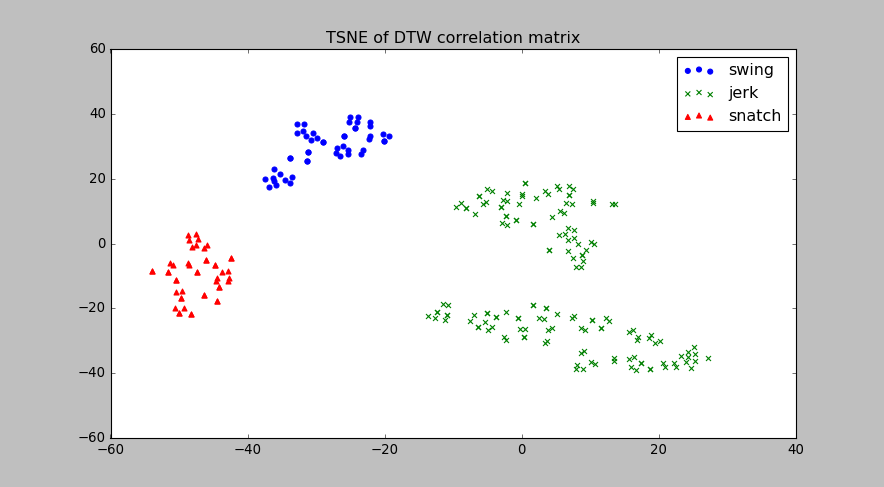

In [81]:
# implement t-SNE for illustration purposes
from dtaidistance import dtw
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# dtw.distance_fast(s1,s2)
x_data=total_df['gF2d'].to_list()
label_data=total_df['label'].values
n_samples=len(x_data)
print(n_samples)
dtw_matrix = np.zeros([n_samples,n_samples])
for i in range(n_samples):
    s1=np.array(x_data[i])
    for j in range(n_samples):
        if i==j:
            dtw_matrix[i,j]=0
        if dtw_matrix[i,j]==0 :
            dtw_matrix[i,j]=dtw.distance_fast(s1[0:50],np.array(x_data[j][0:50]))+dtw.distance_fast(s1[50:-1],np.array(x_data[j][50:-1]))
            dtw_matrix[j,i]= dtw_matrix[i,j]

#kmeans clustering
kmeans_model = KMeans(n_clusters = 5)
clusters = kmeans_model.fit_predict(dtw_matrix)

tsne_visualization(dtw_matrix, kmeans_model.cluster_centers_, label_data)
